# Plot Results of Training Performance
We have run a training performance test on a few different machines, here we assess and contrast performance

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import json
import os

## Load in the Data
We are going to get the data from two sources: (1) Runs on my desktop computer (an [Intel i5 2550K](https://ark.intel.com/content/www/us/en/ark/products/65647/intel-core-i5-2550k-processor-6m-cache-up-to-3-80-ghz.html)) with and without a [GTX 670](https://www.geforce.com/hardware/desktop-gpus/geforce-gtx-670/specifications) GPU and (2) a single node on Theta with the MCDRAM in cache mode.

In [2]:
def load_results(dir_name):
    """Load a summary of the profiling experiment
    
    Args:
        dir_name (str): Path to a directory
    Returns:
        (dict) Dictionary of all the test files
    """
    
    output = {}
    
    # Get the system configuration
    with open(os.path.join(dir_name, 'host_info.json')) as fp:
        host_info = json.load(fp)
        
    host = host_info['hostname']
    output['hostname'] = 'theta' if host.startswith('nid') else host
    output['using_gpu'] = len(host_info['gpus']) > 0
    output['threads'] = int(host_info['accessible_cores'])
    output['using_horovod'] = 'total_ranks' in host_info
    output['total_ranks'] = host_info.get('total_ranks', 1)
    output['ranks_per_node'] = host_info.get('ranks_per_node', 1)
    output['n_nodes'] = output['total_ranks'] // output['ranks_per_node']
    output['threads_per_core'] = output['threads'] * output['ranks_per_node'] // 64
    
    # Get the run configuration
    with open(os.path.join(dir_name, 'run_params.json')) as fp:
        run_info = json.load(fp)
    
    output['n_batches'] = run_info['n_batches']
    output['inter_op'] = run_info['inter_op']
    output['loader_threads'] = run_info['parallel_loader']
    
    # Load the run performance
    with open(os.path.join(dir_name, 'timings.json')) as fp:
        timing = json.load(fp)
        
    output.update(timing)
    
    # Compute the global batch sizes
    output['global_batch_size'] = np.multiply(output['batch_size'], output['total_ranks'])
    
    # Compute the number of training entries per second across all ranks
    output['entry_rate'] = np.multiply(output['batch_size'], output['rate']) * output['total_ranks']
    
    # Compute how long it takes to assess 4.4M entries (size of my training set)
    output['epoch_time'] = 4.4e6 / output['entry_rate']
    
    return output
load_results('29Jan20-191133-nid00004')

{'hostname': 'theta',
 'using_gpu': False,
 'threads': 16,
 'using_horovod': True,
 'total_ranks': 4,
 'ranks_per_node': 4,
 'n_nodes': 1,
 'threads_per_core': 1,
 'n_batches': 512,
 'inter_op': 0,
 'loader_threads': -1,
 'batch_size': [32],
 'rate': [1.9770058428831898],
 'global_batch_size': array([128]),
 'entry_rate': array([253.05674789]),
 'epoch_time': array([17387.40435378])}

In [3]:
results = pd.DataFrame([load_results(os.path.dirname(f)) for f in glob(os.path.join('**', 'timings.json')) +
                       glob(os.path.join('..', 'profile-train', '**', 'timings.json'))])

Figure out how long a single epoch will take for the fastest model

In [4]:
print(f'Minimum epoch time: {np.hstack(results.query("using_horovod")["epoch_time"]).min() :.2f}s')\

Minimum epoch time: 1241.63s


Print out the fastest model

In [5]:
best_config = results.loc[results.query("using_horovod")["epoch_time"].map(min).idxmin()]
print('Best configuration:')
for k in ['n_nodes', 'ranks_per_node', 'threads_per_core']:
    print(f'  {k}: {best_config[k]}')
print(f'  Batch size: {best_config["batch_size"][np.argmin(best_config["epoch_time"])]}')

Best configuration:
  n_nodes: 8
  ranks_per_node: 16
  threads_per_core: 2
  Batch size: 1024


## Optimize Number of Ranks Per Node
Horovod allows us to place more than one model replica per node. As we are not fully using the KNL processor, perhaps training more than one model per node is a good route for accelerating training

In [6]:
subset = results.query('hostname == "theta" and n_nodes==1 and loader_threads>0 and using_horovod and threads_per_core==1').sort_values('ranks_per_node')

Plot the results as a function of global batch size

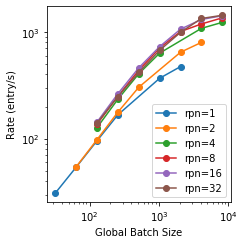

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(3.5, 3.5)

for _, row in subset.iterrows():
    ax.loglog(row['global_batch_size'], row['entry_rate'], 'o-', label=f'rpn={row["ranks_per_node"]}')

ax.legend()
ax.set_xlabel('Global Batch Size')
ax.set_ylabel('Rate (entry/s)')

fig.tight_layout()
fig.savefig('intra-node-parallelism.png', dpi=320)

Plot results at a small global batch size

In [8]:
rates = [x['entry_rate'][list(x['global_batch_size']).index(256)] for _, x in subset.iterrows()]

Text(0, 0.5, 'Rate (entry/s)')

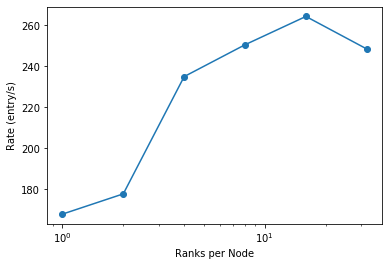

In [9]:
fig, ax = plt.subplots()

ax.semilogx(subset['ranks_per_node'], rates, 'o-')

ax.set_xlabel('Ranks per Node')
ax.set_ylabel('Rate (entry/s)')

*Finding*: We can get a larger throughput for the same global batch size by launching >1 rank per node. The performance seems to max out with 

## Optimize Hyperthreading
The KNL processors on Theta have 4 hardware threads per physical CPU core. We we see if activating them improves performance

In [10]:
subset = results.query('hostname == "theta" and n_nodes==1 and loader_threads>0 and using_horovod and ranks_per_node==16').sort_values('threads_per_core')

Text(0, 0.5, 'Rate (entry/s)')

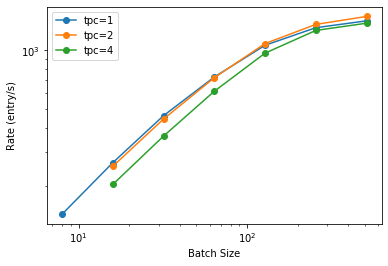

In [11]:
fig, ax = plt.subplots()

for _, row in subset.iterrows():
    if max(row['batch_size']) <= 512:  # Only the small-scale tests
        ax.loglog(row['batch_size'], row['entry_rate'], 'o-', label=f'tpc={row["threads_per_core"]}')

ax.legend()
ax.set_xlabel('Batch Size')
ax.set_ylabel('Rate (entry/s)')

*Finding*: The thread per core becomes slightly more beneficial at larger core counts, but only for 2 threads per core.

## Evaluate Scaling
We want to see how many KNL nodes can work in concert to train our relatively small model.

In [12]:
subset = results.query('hostname == "theta" and loader_threads>0 and using_horovod and ranks_per_node==16 and threads_per_core==2').sort_values('n_nodes')

Plot the performance over batch size

Text(0, 0.5, 'Rate per Node (entry/s)')

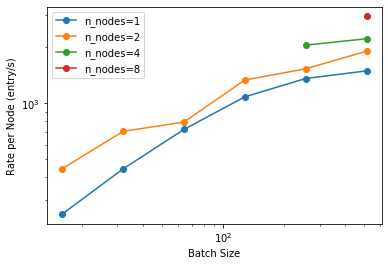

In [13]:
fig, ax = plt.subplots()

for _, row in subset.iterrows():
    if max(row['batch_size']) <= 512:
        ax.loglog(row['batch_size'], row['entry_rate'], 'o-', label=f'n_nodes={row["n_nodes"]}')

ax.legend()
ax.set_xlabel('Batch Size')
ax.set_ylabel('Rate per Node (entry/s)')

*Finding*: We do see the performance increase with batch size, although there are certainly some losses

Plot the rate performance for a single batch size

In [14]:
scaling = []
batch_size = 1024
for _, row in subset.iterrows():
    for batch_size in [512, 1024]:
        if batch_size in row['batch_size']:
            scaling.append({
                'n_nodes': row['n_nodes'],
                'batch_size': batch_size,
                'entry_rate': row['entry_rate'][list(row['batch_size']).index(batch_size)]
            })
scaling = pd.DataFrame(scaling)

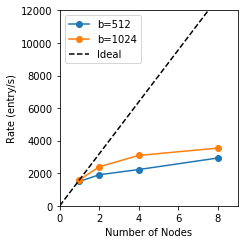

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(3.5, 3.5)

base_rate = scaling.query('n_nodes == 1')['entry_rate'].max()
for batch_size, group in scaling.groupby('batch_size'):
    ax.plot(group['n_nodes'], group['entry_rate'], 'o-', label=f'b={batch_size}')
ax.plot([0, 10], [0, 10 * base_rate], 'k--', label='Ideal')


ax.legend()
ax.set_xlim(0, 9)
ax.set_ylim(0, 12000)
ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Rate (entry/s)')

fig.tight_layout()
fig.savefig('inter-node-parallelism.png', dpi=320)

*Finding*: We do not scale that well with Tensorflow+Horovod for a model that is as quick to run as mine

## Compare Theta to Desktop GPU
Comparing my GTX670 to a KNL

Get a single plot for each

In [16]:
theta = results.query("hostname == 'theta' and inter_op == 1 and n_batches == 128 and not using_horovod")
assert len(theta) == 1
theta = theta.iloc[0]
print(f'Theta averaged over {theta["n_batches"]} batches')

Theta averaged over 128 batches


In [17]:
horovod = results.query("hostname == 'theta' and inter_op == 1 and n_batches == 128 "
                        "and using_horovod and ranks_per_node == 16 and n_nodes == 8 "
                        "and threads_per_core==2")
assert len(horovod) == 1
horovod = horovod.iloc[0]
print(f'Horovod averaged over {theta["n_batches"]} batches')

Horovod averaged over 128 batches


In [18]:
gpu = results.query("hostname == 'Logan-Desktop' and using_gpu and n_batches == 128")
assert len(gpu) == 1
gpu = gpu.iloc[0]
print(f'GPU averaged over {gpu["n_batches"]} batches')

GPU averaged over 128 batches


Plot the data 

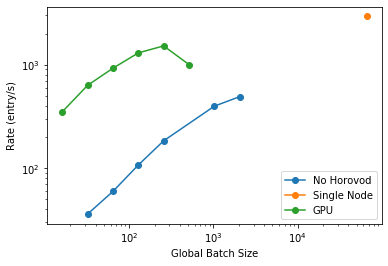

In [19]:
fig, ax = plt.subplots()

ax.loglog(theta['batch_size'], theta['entry_rate'], 'o-', label='No Horovod')
ax.loglog(horovod['global_batch_size'], horovod['entry_rate'], 'o-', label='Single Node')
ax.loglog(gpu['batch_size'], gpu['entry_rate'], 'o-', label='GPU')

ax.set_xlabel('Global Batch Size')
ax.set_ylabel('Rate (entry/s)')
ax.legend()

*Finding*: The KNL and GPU are equal in throughput rate, but requires a larger global batch size (number of replicas times the batch size per replica)